### Problem Statement

Diabetes is one of the most frequent diseases worldwide and the number of diabetic patients is growing over the years. The main cause of diabetes remains unknown, yet scientists believe that both genetic factors and environmental lifestyle play a major role in diabetes. 

Individuals with diabetes face a risk of developing some secondary health issues such as heart diseases and nerve damage. Thus, early detection and treatment of diabetes can prevent complications and assist in reducing the risk of severe health problems. 
Even though it's incurable, it can be managed by treatment and medication.

Researchers at the Bio-Solutions lab want to get better understanding of this disease among women and are planning to use machine learning models that will help them to identify patients who are at risk of diabetes. 

We will use logistic regression to model the "Pima Indians Diabetes" data set. In particular, all patients here are females at least 21 years old of Pima Indian heritage. This model will predict which people are likely to develop diabetes.

## Data Description:

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration over 2 hours in an oral glucose tolerance test
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* Pedigree: Diabetes pedigree function - A function that scores likelihood of diabetes based on family history.
* Age: Age in years
* Class: Class variable (0: the person is not diabetic or 1: the person is diabetic)

### Import necessary libraries

In [1]:
# To filter the warnings
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# this will help in making the Python code more structured automatica/lly (good coding practice)
#%load_ext nb_black

### Read the dataset

In [2]:
data = pd.read_csv("/content/PIMA_INDIAN_DIABATIES.CSV")

### View the first and last 5 rows of the dataset

In [3]:
data.head()

,Pregnancies,Glucose,Insulin,BMI,Pedigree,Age,Class
0,6,148.0,155.548223,33.6,0.627,50,1
1,1,85.0,155.548223,26.6,0.351,31,0
2,8,183.0,155.548223,23.3,0.672,32,1
3,1,89.0,94.000000,28.1,0.167,21,0
4,0,137.0,168.000000,43.1,2.288,33,1


In [4]:
data.tail()

,Pregnancies,Glucose,Insulin,BMI,Pedigree,Age,Class
763,10,101.0,180.000000,32.9,0.171,63,0
764,2,122.0,155.548223,36.8,0.340,27,0
765,5,121.0,112.000000,26.2,0.245,30,0
766,1,126.0,155.548223,30.1,0.349,47,1
767,1,93.0,155.548223,30.4,0.315,23,0


### Understand the shape of the dataset

In [5]:
data.shape

(768, 7)

* There are 768 observations and 7 columns in the dataset

In [6]:
data.isnull().values.any()

False

* We don't have missing values in the data.

### Let's look at the distribution of target variable

In [7]:
data["Class"].value_counts()

0    500
1    268
Name: Class, dtype: int64

In [8]:
data["Class"].value_counts(1)

0    0.651042
1    0.348958
Name: Class, dtype: float64

* The number of observations where the person is non-diabetic are 500 which is 65% of the total data available.

### Splitting data into train and test

In [9]:
X = data.drop(["Class"], axis=1)
Y = data["Class"]

# creating dummies
X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)

**The Stratify argument maintains the original distribution of classes in the target variable while splitting the data into train and test sets.**

### Model Performance Check

**Let's check the performance of the model using different metrics.**

* We will be using metric functions defined in sklearn for Accuracy, Recall, Precision, and F1 score.
* We will create a function which will print out all the above metrics in one go.

In [10]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
  

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
          },
        index=[0],
    )

    return df_perf

#### The confusion matrix

* True Positives (TP):  A person has diabetes and the model predicted person has diabetes.
* True Negatives (TN): A person doesn't have diabetes and the model predicted person doesn't have diabetes.
* False Positives (FP): The model predicted person has diabetes but the person doesn't have diabetes.
* False Negatives (FN): The model predicted person doesn't have diabetes but the person has diabetes.

In [11]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [12]:
knn = KNeighborsClassifier()

# We select the optimal value of K for which the error rate is the least in the validation data
# Let us loop over a few values of K to determine the optimal value of K

train_error = []

test_error = []

knn_many_split = {}

error_df_knn = pd.DataFrame()

features = X.columns

for k in range(1, 15):
    train_error = []
    
    test_error = []
    
    lista = []
    
    knn = KNeighborsClassifier(n_neighbors = k)
    
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        # Fitting K-NN on the training data
        knn.fit(x_train_new, y_train_new)
        
        # Calculating error on the training data and the validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        
        test_error.append(1 - knn.score(x_val, y_val))
    
    lista.append(sum(train_error)/len(train_error))
    
    lista.append(sum(test_error)/len(test_error))
    
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.3070987654320988],
 2: [0.14933954933954932, 0.2790123456790123],
 3: [0.14141414141414146, 0.25740740740740736],
 4: [0.17381507381507383, 0.2712962962962962],
 5: [0.17785547785547787, 0.25833333333333336],
 6: [0.20031080031080029, 0.2506172839506172],
 7: [0.19650349650349652, 0.24814814814814815],
 8: [0.20054390054390056, 0.25030864197530867],
 9: [0.19860139860139855, 0.22870370370370366],
 10: [0.19914529914529908, 0.24876543209876545],
 11: [0.1982128982128982, 0.24166666666666664],
 12: [0.20885780885780889, 0.23703703703703705],
 13: [0.20473970473970474, 0.24475308641975319],
 14: [0.21033411033411034, 0.2601851851851852]}

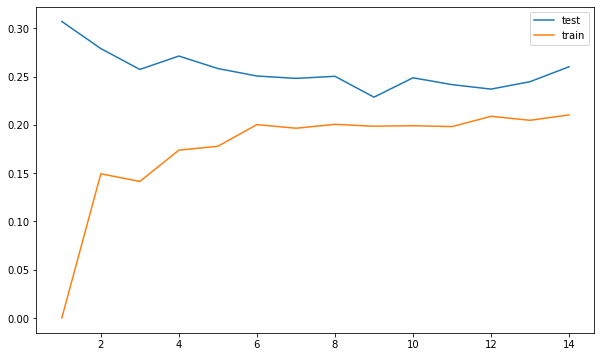

In [13]:
kltest = []

vltest = []

for k, v in knn_many_split.items():
    kltest.append(k)
    
    vltest.append(knn_many_split[k][1])

kltrain = []

vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    
    vltrain.append(knn_many_split[k][0])

# Plotting K vs Error
plt.figure(figsize = (10, 6))

plt.plot(kltest, vltest, label = 'test' )

plt.plot(kltrain, vltrain, label = 'train')

plt.legend()

plt.show()

**Observations:**
- We can see that the test error (error on the validation data) is more or less similar for K greater than or equal to 8. But the training error keeps increasing with increasing K.
- This implies that we would get a lower train and test error if we choose K = 8. Also, if we choose a higher value of K, the model would get biased due to the imbalance in the dataset.
- So, let's fit the K-NN model with **K=8** on the entire training set.

In [24]:
# Define K-NN model
knn = KNeighborsClassifier(n_neighbors = 6)

In [25]:
# Fitting data to the K-NN model
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=6)

In [26]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
model_train_perf = model_performance_classification_sklearn(knn, X_train, y_train)
model_train_perf

Training Performance



,Accuracy,Recall,Precision,F1
0,0.798883,0.582888,0.784173,0.668712


In [27]:
# checking model performance on test set (seen 30% data)
print("Test Performance\n")
model_test_perf = model_performance_classification_sklearn(knn, X_test, y_test)
model_test_perf

Test Performance



,Accuracy,Recall,Precision,F1
0,0.718615,0.432099,0.648148,0.518519


### Hyperparameter Tuning

In [28]:
params_knn = {'n_neighbors': np.arange(3, 15), 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

grid_knn = GridSearchCV(estimator = knn, param_grid = params_knn, scoring = 'recall', cv = 10)

model_knn = grid_knn.fit(X_train,y_train)

knn_estimator = model_knn.best_estimator_

print(knn_estimator)

KNeighborsClassifier(n_neighbors=11)


In [29]:
# Fit the best estimator on the training data
knn_estimator.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [30]:
# checking model performance on train set (seen 70% data)
print("Training Performance\n")
model_train_perf = model_performance_classification_sklearn(knn_estimator, X_train, y_train)
model_train_perf

Training Performance



,Accuracy,Recall,Precision,F1
0,0.800745,0.657754,0.740964,0.696884


In [31]:
# checking model performance on test set (seen 30% data)
print("Test Performance\n")
model_test_perf = model_performance_classification_sklearn(knn_estimator, X_test, y_test)
model_test_perf

Test Performance



,Accuracy,Recall,Precision,F1
0,0.701299,0.506173,0.585714,0.543046


**Observations:**

- This model seems to be overfitting but **the results have significantly improved** in comparison to previous models.
- **Test recall and precision have significantly increased** by tuning the K-NN classifier.